In [1]:
import dolfin
import bempp.api
from bempp.api.external.fenics import FenicsOperator
from dolfin_utils.meshconvert import meshconvert
import numpy as np
from bempp.api.external import fenics
from scipy.sparse.linalg import cg, minres
import pylab as plt
import time

from scipy.sparse.linalg import gmres
from scipy.sparse.linalg import LinearOperator
from bempp.api.assembly.discrete_boundary_operator import InverseSparseDiscreteBoundaryOperator
from bempp.api.assembly.blocked_operator import BlockedDiscreteOperator

from bempp.api.operators.boundary import sparse, laplace, modified_helmholtz
from bempp.api.operators.potential import laplace as lp
 
tol = 1e-06

#Entry data
Q = np.array([1.0,1.0,0.75])
PC=np.array([[1,0,0],[0.7,0.7,0],[-0.5,-0.5,0]])
R = np.array([2., 2., 2.])
w = 0.150 #kappa
es = 80.  #[-]
em = 4.    #[-]

ec = 1.602176e-19 #[C]
kb = 1.380648e-23 #[J/K]
T  = 300 #[K]
S1 = 1 #(ec/(kb*T))  #38.681 [C/J]

FEM_u_error = []
BEM_u_error = []
BEM_lambda_error = []
error_between = []

vac_FEM_u_error = []
vac_BEM_u_error = []
vac_BEM_lambda_error = []
vac_error_between = []

FEM_solv_error = []
BEM_solv_error = []

mesh_size = []
iter_num = []
time_solve = []
vac_iter_num = []
vac_time_solve = []

grid_size = [0, 1, 2, 3]#, 4]

#Analytical solvation energy#
from an_solution import an_P
Ri = 2

G2 = an_P(Q, PC, em, es, Ri, w, Ri , 10)
print(G2)

-164.58633094764338


In [2]:
for m in grid_size:
    ######################### Mesh and spaces ##################################
    import os.path

    if not os.path.isfile("mesh_sphere_"+format(m)+".xml"):
        mesh_file = "Sphere_R_"+format(Ri)+"_h_2_"+format(m)+".msh"
#         meshconvert.convert2xml(mesh_file, "mesh_sphere_"+format(m)+".xml", iformat=None)
        meshconvert.gmsh2xml(mesh_file, "mesh_sphere_"+format(m)+".xml", iformat=None)
        
    mesh = dolfin.Mesh("mesh_sphere_"+format(m)+".xml")  
     
    nor = dolfin.FacetNormal(mesh) 
    
    # Spaces for FEM and BEM
    fenics_space = dolfin.FunctionSpace(mesh, "CG", 1)
    trace_space, trace_matrix = \
        fenics.fenics_to_bempp_trace_data(fenics_space)
    bempp_space = bempp.api.function_space(trace_space.grid, "P", 1)

    print("FEM dofs: {0}".format(mesh.num_vertices()))
    print("BEM dofs: {0}".format(bempp_space.global_dof_count))
   
    hmax = trace_space.grid.maximum_element_diameter
    mesh_size.append(hmax)
    
    # FEM discrete variables
    u = dolfin.TrialFunction(fenics_space)
    v = dolfin.TestFunction(fenics_space)
    
    # BEM operators
    id_op = bempp.api.operators.boundary.sparse.identity(trace_space, bempp_space, bempp_space)
    mass = bempp.api.operators.boundary.sparse.identity(bempp_space, bempp_space, trace_space)

    dlp_0 = bempp.api.operators.boundary.laplace.double_layer(trace_space, bempp_space, bempp_space)
    slp_0 = bempp.api.operators.boundary.laplace.single_layer(bempp_space, bempp_space, bempp_space) 

    dlp = bempp.api.operators.boundary.modified_helmholtz.double_layer(trace_space, bempp_space, bempp_space, w)
    slp = bempp.api.operators.boundary.modified_helmholtz.single_layer(bempp_space, bempp_space, bempp_space, w)

    ######################### Matrix and RHS ##################################
    
    # RHS for FEM
    rhs_f = dolfin.Constant(0.0)
    rhs_fem = dolfin.assemble(rhs_f*v*dolfin.dx)
    for i in range(len(PC)):
        delta = dolfin.PointSource(fenics_space, dolfin.Point(PC[i]), Q[i]/em)
        delta.apply(rhs_fem)
    # RHS for BEM
    rhs_bem = np.zeros(bempp_space.global_dof_count)
    # Global RHS
    rhs = np.concatenate([rhs_fem, rhs_bem])
    
    
    blocks = [[None,None],[None,None]]
    blocks_vac = [[None,None],[None,None]]
    
    # FEM matrices
    trace_op = LinearOperator(trace_matrix.shape, lambda x:trace_matrix*x)

    A = FenicsOperator((dolfin.inner(dolfin.nabla_grad(u),
                                     dolfin.nabla_grad(v)) ) * dolfin.dx)  
    # Solvant case
    B00 = A.weak_form()
    B01 = -trace_matrix.T * mass.weak_form().A
    B10 = (.5 * id_op - dlp).weak_form().A * trace_matrix
    B11 = slp.weak_form().A*(em/es)
    blocks[0][0] = B00.A  #A
    blocks[0][1] = B01  #-ML
    blocks[1][0] = B10  #0.5-K
    blocks[1][1] = B11  #V

    blocked = BlockedDiscreteOperator(np.array(blocks))
    
    # Vaccum case
    B10 = (.5 * id_op - dlp_0).weak_form().A * trace_matrix
    B11 = slp_0.weak_form().A
    blocks_vac[0][0] = B00.A  #A
    blocks_vac[0][1] = B01  #-ML
    blocks_vac[1][0] = B10  #0.5-K
    blocks_vac[1][1] = B11  #V

    blocked_vacuum = BlockedDiscreteOperator(np.array(blocks_vac))
    
    ######################### Preconditioner and solvers ##################################
    
#     # Compute the sparse inverse of the Helmholtz operator
#     # Although it is not a boundary operator we can use
#     # the SparseInverseDiscreteBoundaryOperator function from
#     # BEM++ to turn its LU decomposition into a linear operator.
#     P1 = InverseSparseDiscreteBoundaryOperator(
#         blocks[0][0].tocsc())

    # For the Laplace slp we use a simple mass matrix preconditioner. 
    # This is sufficient for smaller low-frequency problems.
    P2 = InverseSparseDiscreteBoundaryOperator(
        bempp.api.operators.boundary.sparse.identity(
            bempp_space, bempp_space, bempp_space).weak_form())

    # Create a block diagonal preconditioner object using the Scipy LinearOperator class
    def apply_prec(x):
        """Apply the block diagonal preconditioner"""
        m1 = blocked[0,0].shape[0]
        m2 = P2.shape[0]
        n1 = blocked[0,0].shape[1]
        n2 = P2.shape[1]

        res1 = (x[:n1]) #P1.dot
        res2 = P2.dot(x[n1:])
        return np.concatenate([res1, res2])

    p_shape = (blocked[0,0].shape[0] + P2.shape[0], blocked[0,0].shape[1] + P2.shape[1])
    P = LinearOperator(p_shape, apply_prec, dtype=np.dtype('float64'))

    # Solvant case
    it_count = 0
    def count_iterations(x):
        global it_count
        it_count += 1

    from scipy.sparse.linalg import gmres
    start = time.time()     
    soln, info = gmres(blocked, rhs, M=P, callback=count_iterations, tol=tol, restrt=500)  
    end = time.time()
    curr_time = (end - start) 
    time_solve.append(curr_time)   
    
    soln_fem = soln[:mesh.num_vertices()]
    soln_bem = soln[mesh.num_vertices():]

    print("Number of iterations: {0}".format(it_count))
    iter_num.append(it_count)
    
    u = dolfin.Function(fenics_space)
    u.vector()[:] = np.ascontiguousarray(np.real(soln_fem))
    dirichlet_data = trace_matrix * soln_fem
    dirichlet_fun = bempp.api.GridFunction(trace_space, coefficients=dirichlet_data)
    neumann_fun = bempp.api.GridFunction(bempp_space, coefficients=soln_bem)
    
    # Vaccum case
    it_count = 0
    start = time.time()     
    soln_vacuum, info = gmres(blocked_vacuum, rhs, M=P, callback=count_iterations, tol=tol, restrt=500)   
    end = time.time()
    curr_time = (end - start) 
    vac_time_solve.append(curr_time)
    
    vac_soln_fem = soln_vacuum[:mesh.num_vertices()]
    vac_soln_bem = soln_vacuum[mesh.num_vertices():]

    print("Number of iterations (vacuum case): {0}".format(it_count))
    vac_iter_num.append(it_count)
    
    u_vac = dolfin.Function(fenics_space)
    u_vac.vector()[:] = np.ascontiguousarray(np.real(vac_soln_fem))
    vac_dirichlet_data = trace_matrix * vac_soln_fem
    vac_dirichlet_fun = bempp.api.GridFunction(trace_space, coefficients=vac_dirichlet_data)
    vac_neumann_fun = bempp.api.GridFunction(bempp_space, coefficients=vac_soln_bem)
    
    ######################### Solvation energy ##################################
    
    slpF = bempp.api.operators.potential.laplace.single_layer(bempp_space, np.transpose(PC)) 
    dlpF = bempp.api.operators.potential.laplace.double_layer(trace_space, np.transpose(PC))

    uF = slpF * neumann_fun - dlpF * dirichlet_fun
    uF_vac = slpF * vac_neumann_fun - dlpF * vac_dirichlet_fun 
    
    FEM_q_uF = 0
    BEM_q_uF = 0
    for i in range(len(PC)):
        BEM_Sum = (uF[0][i].real- uF_vac[0][i].real)*Q[i]
        FEM_Sum = (u(PC[i]) - u_vac(PC[i]))*Q[i] 
        BEM_q_uF = BEM_q_uF + BEM_Sum
        FEM_q_uF = FEM_q_uF + FEM_Sum

    BEM_E_Solv = 0.5*4.*np.pi*332.064*(BEM_q_uF) 
    print('Energia de Solvatacion (BEM): {:7.3f} [kCal/mol]'.format(BEM_E_Solv))
    BEM_Error = np.abs( BEM_E_Solv/G2-1 )*100
    print('{:.4f}%'.format(BEM_Error))
                     
    FEM_E_Solv = 0.5*4.*np.pi*332.064*(FEM_q_uF) 
    print('Energia de Solvatacion (FEM): {:7.3f} [kCal/mol]'.format(FEM_E_Solv))
    FEM_Error = np.abs(FEM_E_Solv/G2-1 )*100
    print('{:.4f}%'.format(FEM_Error))
    
    FEM_solv_error.append(FEM_Error)
    BEM_solv_error.append(BEM_Error)    

FEM dofs: 143
BEM dofs: 116


/usr/lib/python3/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


Number of iterations: 122
Number of iterations (vacuum case): 64
Energia de Solvatacion (BEM): -168.375 [kCal/mol]
2.3019%
Energia de Solvatacion (FEM): -171.444 [kCal/mol]
4.1665%
FEM dofs: 457
BEM dofs: 316


/usr/lib/python3/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


Number of iterations: 196
Number of iterations (vacuum case): 83
Energia de Solvatacion (BEM): -166.022 [kCal/mol]
0.8725%
Energia de Solvatacion (FEM): -167.544 [kCal/mol]
1.7973%
FEM dofs: 2303
BEM dofs: 1062


/usr/lib/python3/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


Number of iterations: 236
Number of iterations (vacuum case): 104
Energia de Solvatacion (BEM): -164.931 [kCal/mol]
0.2095%
Energia de Solvatacion (FEM): -164.944 [kCal/mol]
0.2171%
FEM dofs: 15880
BEM dofs: 4184


/usr/lib/python3/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


Number of iterations: 226
Number of iterations (vacuum case): 141
Energia de Solvatacion (BEM): -164.672 [kCal/mol]
0.0520%
Energia de Solvatacion (FEM): -164.667 [kCal/mol]
0.0491%


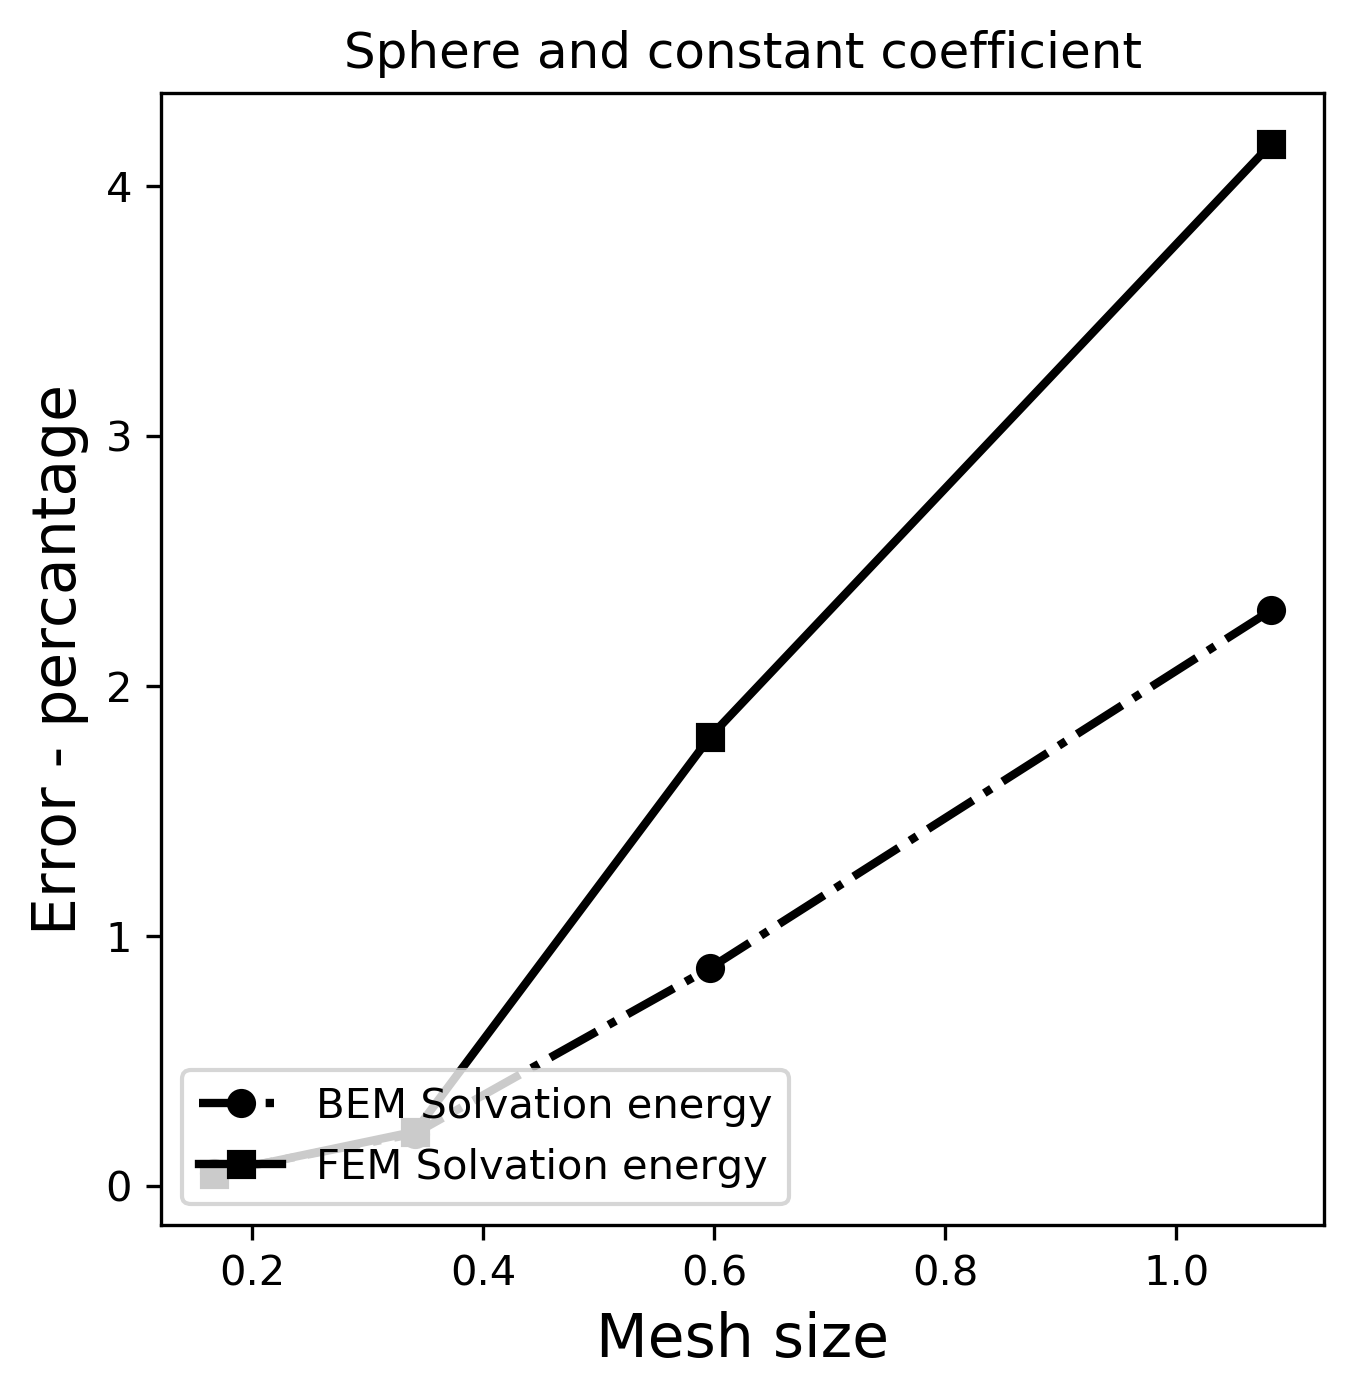

In [3]:
from operator import add
import matplotlib.pyplot as plt

# # mesh_size = list_radius
# log_mesh_size = np.log(mesh_size)
# inv_mesh_size =  np.true_divide(1, mesh_size)

# mult = abs(BEM_solv_error[len(mesh_size)//2]/mesh_size[len(mesh_size)//2])
# o_mesh_size = np.multiply(mult, mesh_size)

# mesh_pow_2 = np.multiply(mesh_size, mesh_size)
# mult = 1.5*abs(BEM_solv_error[len(mesh_size)//2]/mesh_pow_2[len(mesh_size)//2])
# o_mesh_pow_2 = np.multiply(mult, mesh_pow_2)

# mesh_pow_3 = np.multiply(mesh_pow_2, mesh_size)
# mult = abs(BEM_solv_error[len(mesh_size)//2]/mesh_pow_3[len(mesh_size)//2])
# o_mesh_pow_3 = np.multiply(mult, mesh_pow_3)

plt.figure( figsize=(5, 5), dpi=300)
# plt.loglog(mesh_size, error_between, 'ks-', linewidth=2, label='Relative Dirichlet jump')
plt.plot(mesh_size, BEM_solv_error, 'ko-.', linewidth=2, label='BEM Solvation energy')
plt.plot(mesh_size, FEM_solv_error, 'ks-', linewidth=2, label='FEM Solvation energy')
# plt.loglog(mesh_size, o_mesh_size, 'k:', linewidth=1, label='O(h)')
# plt.loglog(mesh_size, o_mesh_pow_2, 'k:', linewidth=2, label='O(h^2)')
# plt.loglog(mesh_size, o_mesh_pow_3, 'k--', linewidth=1, label='O(h^3)')
plt.legend(loc='lower left')
plt.title('Sphere and constant coefficient')
plt.xlabel('Mesh size', fontsize='x-large')
plt.ylabel('Error - percantage', fontsize='x-large')
plt.show()

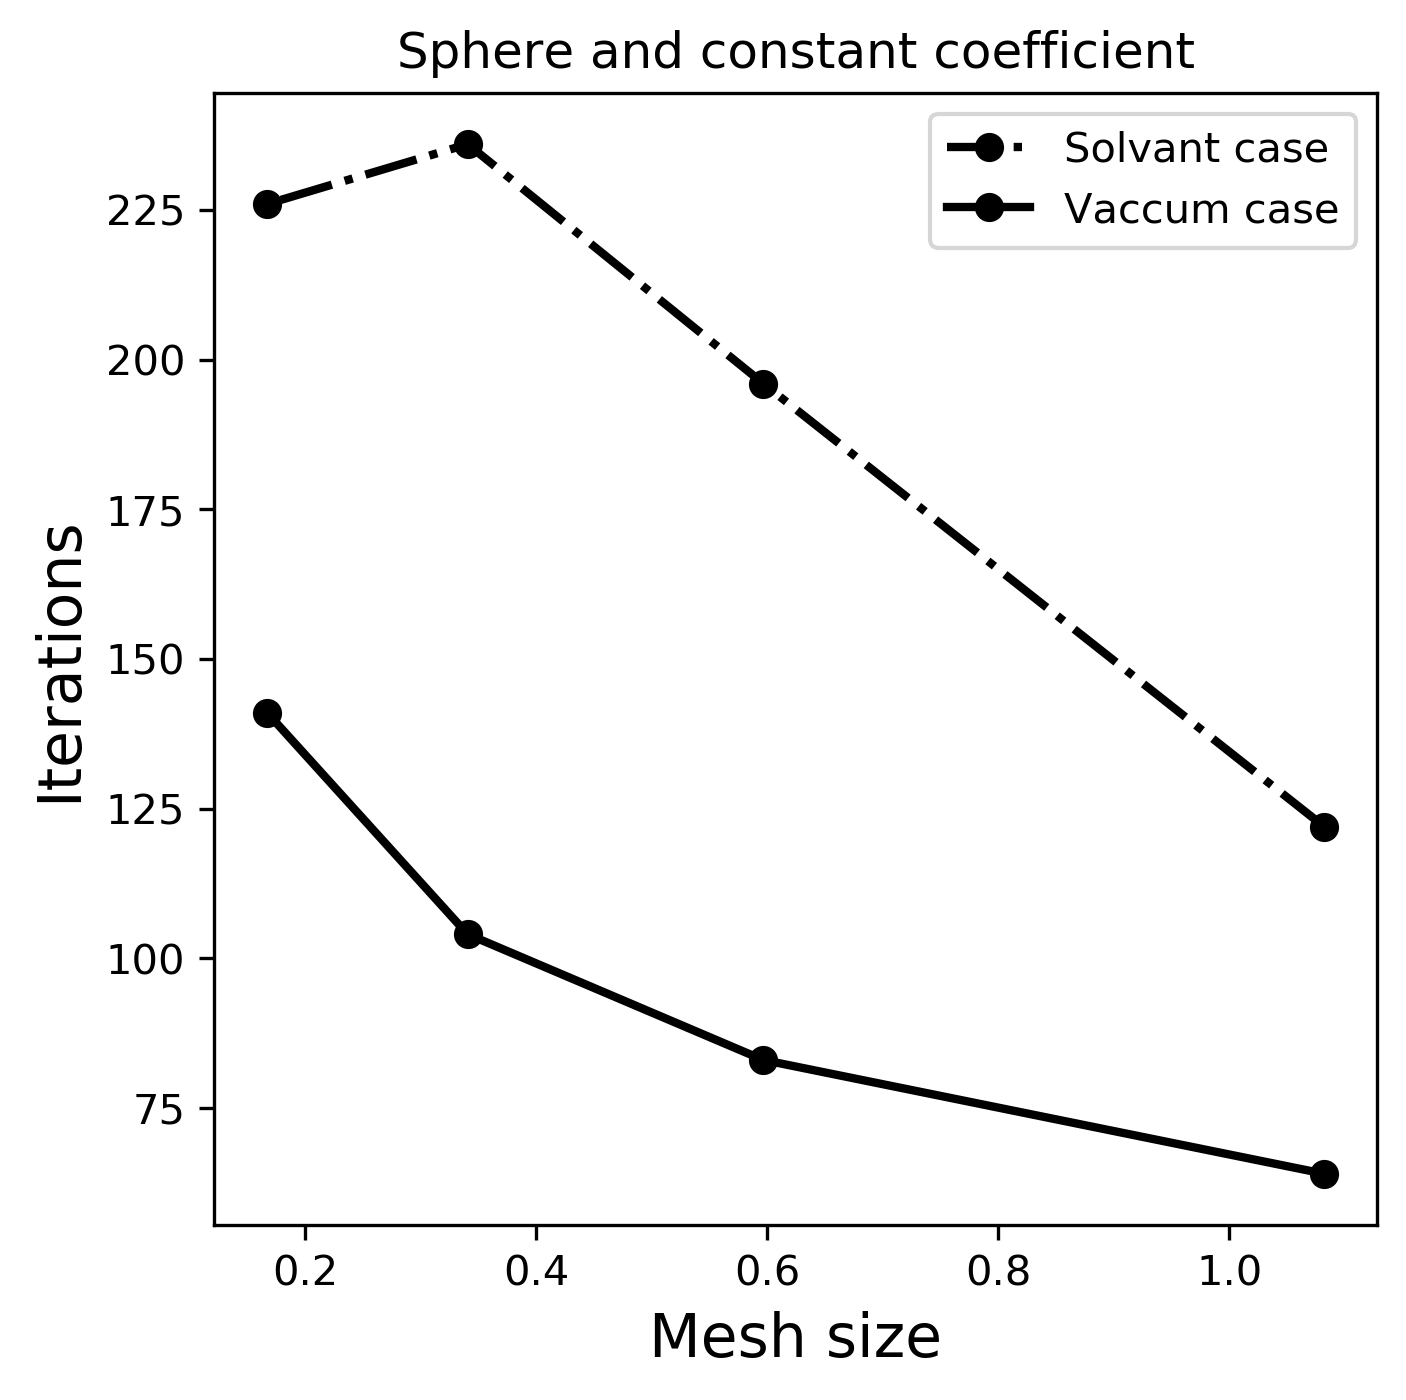

In [4]:
import matplotlib.pyplot as plt

log_mesh_size = np.log(mesh_size)

plt.figure( figsize=(5, 5), dpi=300)
plt.plot(mesh_size, iter_num, 'ko-.', linewidth=2, label='Solvant case')
plt.plot(mesh_size, vac_iter_num, 'ko-', linewidth=2, label='Vaccum case')
plt.legend(loc='upper right')
plt.title('Sphere and constant coefficient')
plt.xlabel('Mesh size', fontsize='x-large')
plt.ylabel('Iterations', fontsize='x-large')
plt.show()

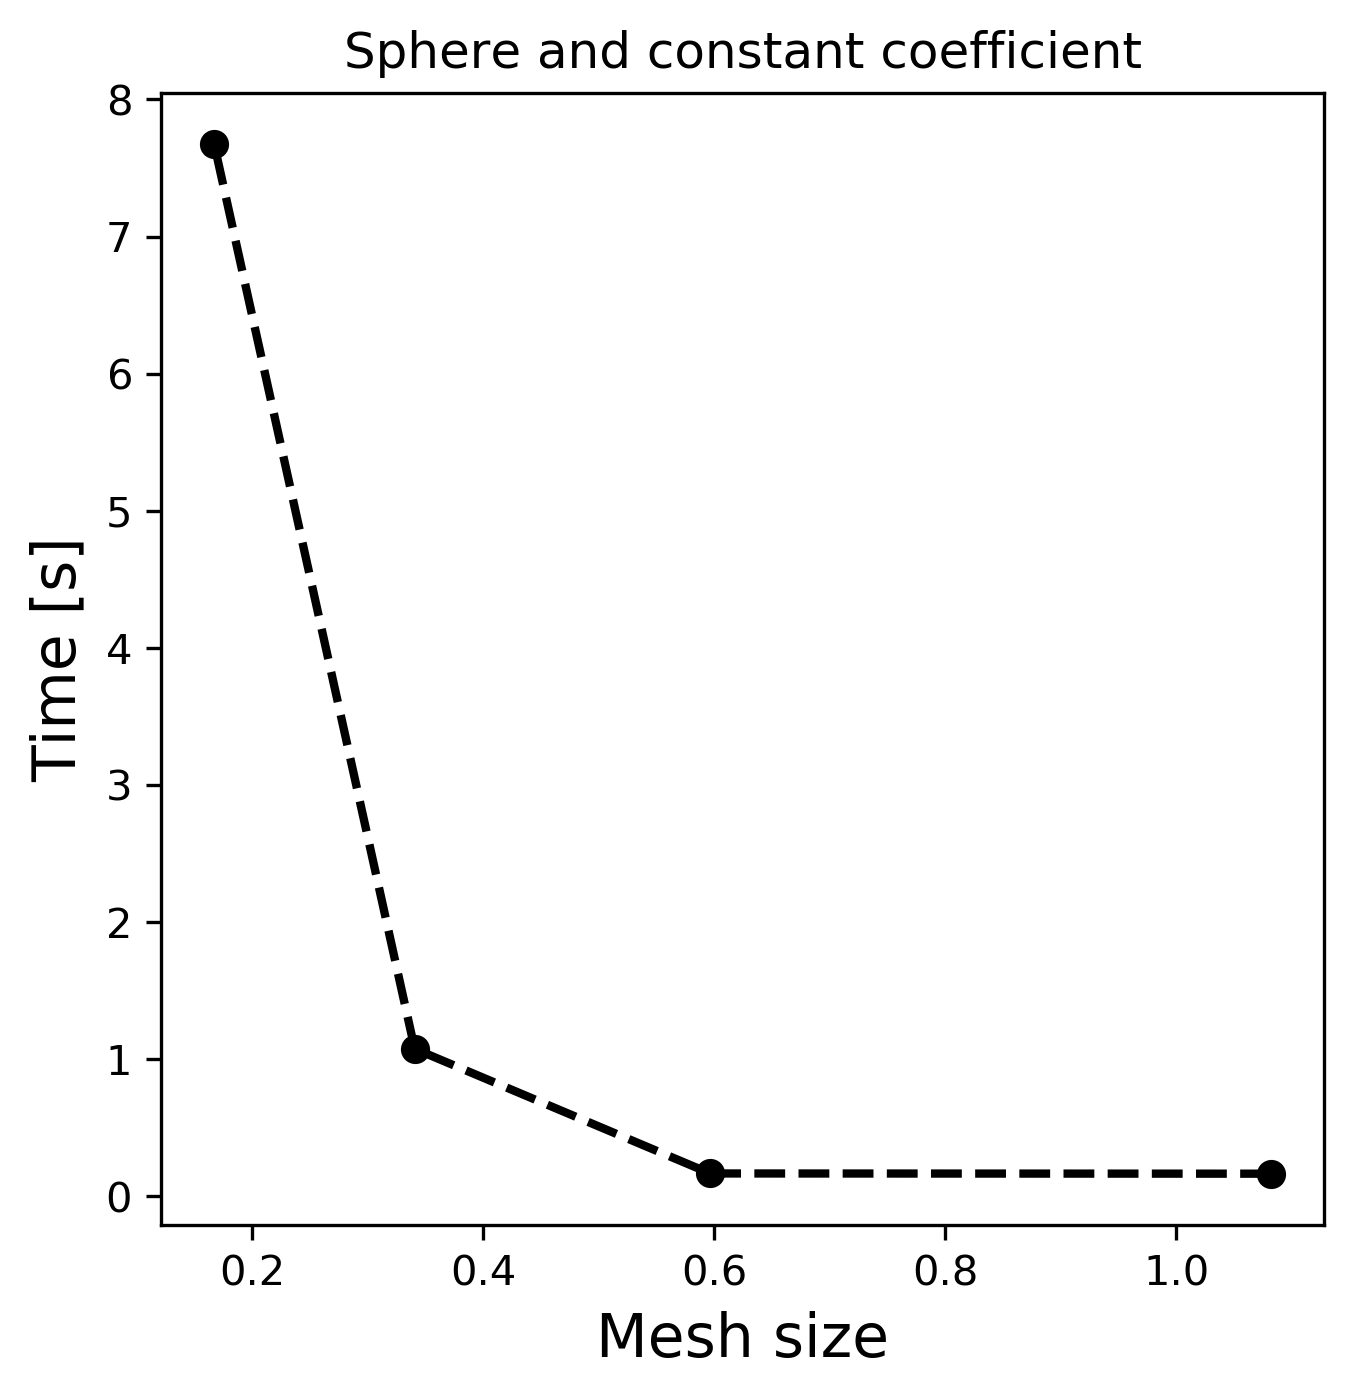

In [5]:
import matplotlib.pyplot as plt

log_mesh_size = np.log(mesh_size)

plt.figure( figsize=(5, 5), dpi=300)
plt.plot(mesh_size, np.add(time_solve, vac_time_solve), 'ko--', linewidth=2)
# plt.plot(mesh_size, time_solve, 'ko--', linewidth=2, label='Solvant case')
# plt.plot(mesh_size, vac_time_solve, 'ko-', linewidth=2, label='Vacuum case')
plt.title('Sphere and constant coefficient')
plt.xlabel('Mesh size', fontsize='x-large')
plt.ylabel('Time [s]', fontsize='x-large')
plt.show()